In [1]:
# Install required packages
!pip install timm

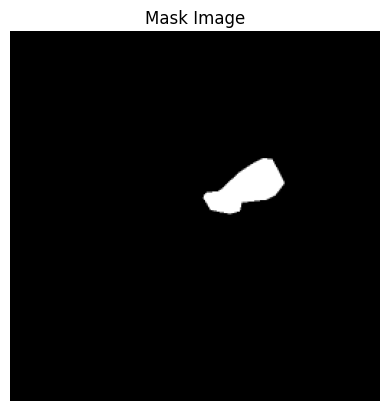

In [15]:
mask = cv2.imread("/kaggle/input/brain-tumor-segmentation/masks/1.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256, 256))
mask = mask.astype(np.float32) / 255.0  # Normalize mask to [0,1]
mask.shape
plt.imshow(mask, cmap='gray')
plt.title('Mask Image')
plt.axis('off')
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import timm
import matplotlib.pyplot as plt

# Define the Dataset
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        mask_name = self.masks[idx]

        image_path = os.path.join(self.images_dir, image_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        # Load image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        image = image.astype(np.float32) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = mask.astype(np.float32) / 255.0  # Normalize mask to [0,1]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1))  # HWC to CHW
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dimension

        return image, mask

In [ ]:
# Define the ViT-based Segmentation Model
class ViTSegmentationModel(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(ViTSegmentationModel, self).__init__()
        # Load a pretrained ViT model
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=pretrained, img_size=256)
        self.n_patches = self.backbone.patch_embed.num_patches  # Should be 16*16=256
        self.hidden_dim = self.backbone.embed_dim  # Should be 768 for vit_base

        # Remove the classifier head
        self.backbone.reset_classifier(0)

        # Define the decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.hidden_dim, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2),
            # Sigmoid activation will be applied during inference
        )

    def forward(self, x):
        # x: [B, 3, 256, 256]
        B = x.shape[0]
        # Extract patches and embeddings
        x = self.backbone.patch_embed(x)  # [B, n_patches, hidden_dim]
        cls_token = self.backbone.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.backbone.pos_embed
        x = self.backbone.pos_drop(x)

        # Transformer blocks
        for blk in self.backbone.blocks:
            x = blk(x)
        x = self.backbone.norm(x)

        # Remove class token and reshape
        x = x[:, 1:, :]  # [B, n_patches, hidden_dim]
        h = w = int(self.n_patches ** 0.5)  # Should be 16
        x = x.transpose(1, 2).reshape(B, self.hidden_dim, h, w)  # [B, hidden_dim, h, w]

        # Decoder to upsample to original image size
        x = self.decoder(x)  # [B, num_classes, 256, 256]
        return x

Epoch 1/30: Train Loss: 0.2538, Train Acc: 0.9603, Val Loss: 0.1580, Val Acc: 0.9831
Epoch 2/30: Train Loss: 0.1341, Train Acc: 0.9832, Val Loss: 0.1097, Val Acc: 0.9839
Epoch 3/30: Train Loss: 0.0922, Train Acc: 0.9862, Val Loss: 0.0800, Val Acc: 0.9862
Epoch 4/30: Train Loss: 0.0707, Train Acc: 0.9893, Val Loss: 0.0636, Val Acc: 0.9895
Epoch 5/30: Train Loss: 0.0560, Train Acc: 0.9914, Val Loss: 0.0532, Val Acc: 0.9904
Epoch 6/30: Train Loss: 0.0451, Train Acc: 0.9929, Val Loss: 0.0439, Val Acc: 0.9918
Epoch 7/30: Train Loss: 0.0387, Train Acc: 0.9933, Val Loss: 0.0399, Val Acc: 0.9916
Epoch 8/30: Train Loss: 0.0321, Train Acc: 0.9942, Val Loss: 0.0351, Val Acc: 0.9925
Epoch 9/30: Train Loss: 0.0274, Train Acc: 0.9949, Val Loss: 0.0372, Val Acc: 0.9918
Epoch 10/30: Train Loss: 0.0241, Train Acc: 0.9953, Val Loss: 0.0286, Val Acc: 0.9933
Epoch 11/30: Train Loss: 0.0206, Train Acc: 0.9959, Val Loss: 0.0275, Val Acc: 0.9934
Epoch 12/30: Train Loss: 0.0179, Train Acc: 0.9964, Val Loss: 0

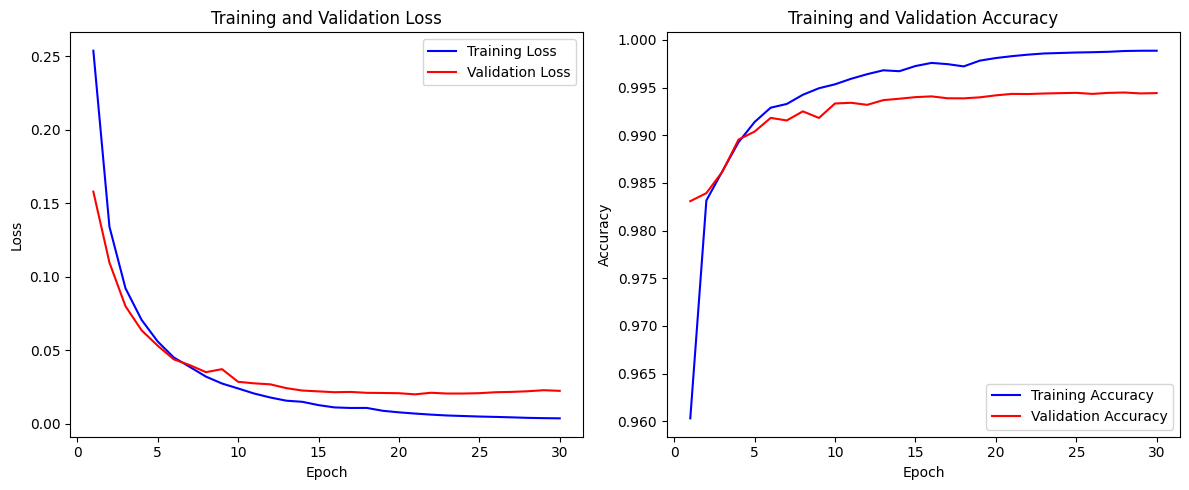

In [17]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths to images and masks
images_dir = '/kaggle/input/brain-tumor-segmentation/images'
masks_dir = '/kaggle/input/brain-tumor-segmentation/masks'

# Create dataset and dataloaders
dataset = BrainTumorSegmentationDataset(images_dir, masks_dir)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Initialize the model
model = ViTSegmentationModel(num_classes=1, pretrained=True)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Initialize lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with accuracy calculation
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        # Compute accuracy
        preds = torch.sigmoid(outputs) > 0.5
        train_correct += (preds == masks.bool()).sum().item()
        train_total += masks.numel()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Compute accuracy
            preds = torch.sigmoid(outputs) > 0.5
            val_correct += (preds == masks.bool()).sum().item()
            val_total += masks.numel()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print('Epoch {}/{}: Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(
        epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

# Plotting the loss and accuracy curves
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

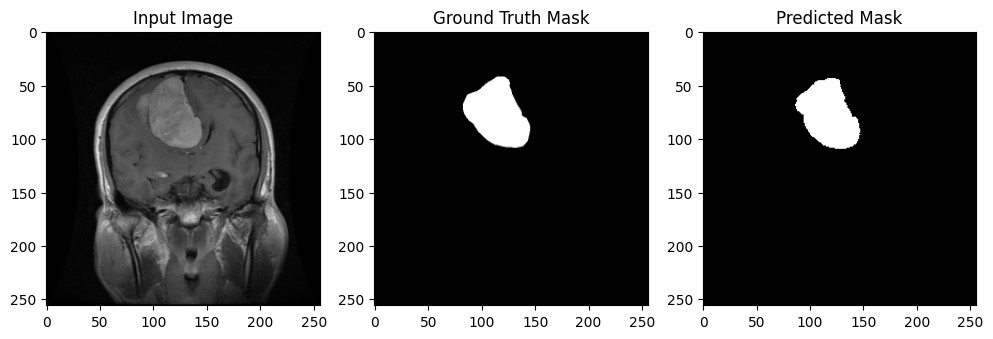

In [19]:
# Visualization with fixes
model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = model(images)
    outputs = torch.sigmoid(outputs)
    preds = outputs > 0.5

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Visualize the first sample
    idx = 0
    image = images[idx].transpose(1, 2, 0)
    mask = masks[idx][0]  # Squeeze channel dimension
    pred = preds[idx][0]  # Squeeze channel dimension

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred, cmap='gray')

    plt.show()

In [5]:
!pip install torchsummary

In [7]:
from torchsummary import summary

# Move model to the appropriate device
model = model.to(device)

# Display the summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 16, 16]         590,592
          Identity-2             [-1, 256, 768]               0
        PatchEmbed-3             [-1, 256, 768]               0
           Dropout-4             [-1, 257, 768]               0
         LayerNorm-5             [-1, 257, 768]           1,536
            Linear-6            [-1, 257, 2304]       1,771,776
          Identity-7          [-1, 12, 257, 64]               0
          Identity-8          [-1, 12, 257, 64]               0
            Linear-9             [-1, 257, 768]         590,592
          Dropout-10             [-1, 257, 768]               0
        Attention-11             [-1, 257, 768]               0
         Identity-12             [-1, 257, 768]               0
         Identity-13             [-1, 257, 768]               0
        LayerNorm-14             [-1, 2